[기초부터 시작하는 NLP: seq2seq with attention 이용한 번역](https://tutorials.pytorch.kr/intermediate/seq2seq_translation_tutorial.html)

## seq2seq with attention

NLP 모델링 작업 위한 데이터 전처리에 사용할 자체 클래스 및 함수 작성\
torchtext가 데이터 전처리 과정을 어떻게 다루는지 알아보기

예)

```bash
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

모델

![](https://tutorials.pytorch.kr/_images/seq2seq.png)

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

## 데이터 파일 로딩

[데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

예)

```
I am cold.    J'ai froid.
```

In [3]:
"""
언어의 각 단어들을 one-hot 벡터로 표현
이후에 네트워크의 입력 및 목표로 사용하기 위해 단어의 고유 번호가 필요
    ㄴ word2index
    ㄴ index2word
    ㄴ word2count: 희귀 단어 대체하는데 사용할 헬퍼 클래스 Lang 사용
"""

SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # SOS, EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# 유니코드 문자 ASCII로 변환, 소문자 변환, 구두점 지우기
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())

    # 찾은 그룹 앞에 공백 추가(안녕? -> 안녕 ?)
    s = re.sub(r"([.!?])", r" \1", s)

    # 알파벳 및 구두점 제외하고 모두 공백으로 변경
    s = re.sub(r"[^a-zA-z.!?]+", r" ", s)
    return s

In [5]:
"""
1. 파일을 라인 단위로 쪼개기
2. 라인을 쌍 단위로 쪼개기
'reverse' 플래그 추가: 다른 언어 -> 영어 쌍을 위해
"""

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 줄을 쌍으로 분리하고 정규화 진행
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Lang 인스턴스 생성, reverse true 일시, 쌍을 뒤집는다
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
# 빠른 학습을 위해 짧고 간단한 문장으로 데이터셋 정리
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes) # startswith(Union[Tuple[str], str])

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
"""
데이터 준비
    ㄴ 텍스트 파일 읽어서 줄로 분리, 줄을 쌍으로 분리
    ㄴ 텍스트 정규화, 길이와 내용으로 필터링
    ㄴ 쌍을 이룬 문장들로 단어 리스트 생성
"""

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)

    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis trop fatigue pour courir .', 'i am too tired to run .']


## Seq2Seq 모델

Seq2Seq(Encoder Decoder network): 두 개의 RNN으로 구성된 모델

* 모델 구조\
![](https://tutorials.pytorch.kr/_images/seq2seq.png)

Seq2Seq의 인코더는 입력 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN\
모든 입력 단어에 대해 인코더는 벡터와 은닉 상태 출력, 다음 입력 단어를 위해 은닉 상태 사용

* 인코더\
![](https://tutorials.pytorch.kr/_images/encoder-network.png)

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # input_size 개수의 임베딩 생성, 임베딩 차원의 크기는 hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(
            1, # 배치 크기: 한 번에 하나의 시퀀스만 처리하도록 함(seq2seq 모델의 특징)
            1, # 시퀀스 길이: 초기 은닉 상태 설정할 때는 한 번에 하나의 시퀀스만 처리하므로 시퀀스 길이는 1
            self.hidden_size,
            device=device
        )

* 디코더\
![](https://tutorials.pytorch.kr/_images/decoder-network.png)

간단한 seq2seq 디코더: 인코더의 마지막 출력만(_문맥 벡터_)을 이용\
디코딩의 매 단계에서 디코더에게 입력 토큰과 은닉 상태가 주어진다
초기 입력 토큰은 `<SOS>`, 첫 은닉 상태는 문맥 벡터

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

* Attention 디코더\
![](https://i.imgur.com/1152PYf.png)

단일 벡터가 전체 문장을 인코딩 해야하는 부담을 없애기 위함\
Attention: 디코더 네트워크가 자기 출력의 모든 단계에서 인코더 출력의 다른 부분에 집중할 수 있도록 한다

<br>

어텐션 가중치 계산은 `attn` 으로 수행된다

모델 구조)\
![](https://tutorials.pytorch.kr/_images/attention-decoder-network.png)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(
        self,
        hidden_size,
        output_size,
        dropout_p=0.1,
        max_length=MAX_LENGTH,
    ):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)),
            dim = 1
        )

        # batch matrix multiplication, 3차원 텐서에 지원
        attn_applied = torch.bmm(
            attn_weights.unsqueeze(0),
            encoder_outputs.unsqueeze(0),
        )

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 학습

In [12]:
"""
학습 데이터 준비

학습을 위해 각 쌍마다 입력 Tensor 및 목표 Tensor가 필요
해당하는 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰 추가하기
"""

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [13]:
"""
모델 학습

1. 인코더에 문장을 넣고 모든 출력과 최신 은닉 상태 추적하기
2. 디코더의 첫 번째 입력으로 <SOS> 토큰과 인코더의 마지막 은닉 상태가 첫번째 은닉 상태로 제공

간단한 if 문으로 teacher forcing 사용 유무 제어 가능
"""

teacher_forcing_ratio = 0.5

def train(
    input_tensor,
    target_tensor,
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    max_length=MAX_LENGTH,
):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei],
            encoder_hidden,
        )
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # 목표를 다음 입력으로 전달하기
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            loss += criterion(decoder_output, target_tensor[di])

            # teacher forcing
            decoder_input = target_tensor[di]

    else:
        # 모델의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            topv, topi = decoder_output.topk(1)

            # 다음 입력으로 사용할 부분을 히스토리에서 분리
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [14]:
# 경과된 시간 및 남은 예상 시간 출력하는 헬퍼 함수 정의
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [20]:
def trainIters(
    encoder,
    decoder,
    n_iters,
    print_every=1000,
    plot_every=100,
    learning_rate=0.01,
):
    start = time.time()
    plot_losses = []
    print_loss_total = 0 # print_every 마다 초기화
    plot_loss_total = 0 # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [
        tensorFromPair(random.choice(pairs))
        for i in range(n_iters)
    ]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(
            input_tensor,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion,
        )

        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [16]:
"""
결과 도식화

저장된 손실 값 plot_losses의 배열을 사용하여 도식화
"""

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()

    # locator가 간격을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
"""
평가

각 단계마다 디코더의 예측을 되돌려 전달
단어를 예측할 때마다 단어를 출력 문자열에 추가하고, EOS토큰을 예측하면 거기서 멈춤

이후 도식화를 위해 디코더의 Attention 출력을 저장
"""

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei],
                encoder_hidden,
            )
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [24]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words , attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 학습과 평가

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

1m 54s (- 26m 46s) (5000 6%) 2.8294
3m 41s (- 23m 56s) (10000 13%) 2.2939
5m 12s (- 20m 51s) (15000 20%) 2.0137
7m 10s (- 19m 42s) (20000 26%) 1.7305
9m 0s (- 18m 1s) (25000 33%) 1.5533
10m 54s (- 16m 21s) (30000 40%) 1.3872
12m 52s (- 14m 43s) (35000 46%) 1.2364
14m 21s (- 12m 34s) (40000 53%) 1.1231
15m 49s (- 10m 32s) (45000 60%) 1.0068
17m 18s (- 8m 39s) (50000 66%) 0.9227
18m 45s (- 6m 49s) (55000 73%) 0.8361
20m 14s (- 5m 3s) (60000 80%) 0.7511
21m 41s (- 3m 20s) (65000 86%) 0.6968
23m 12s (- 1m 39s) (70000 93%) 0.6175
24m 42s (- 0m 0s) (75000 100%) 0.5718


In [25]:
evaluateRandomly(encoder1, attn_decoder1)

> elles approchent .
= they are approaching .
< they are approaching . <EOS>

> je suis tellement perplexe en ce moment .
= i m so confused right now .
< i m so confused right now . <EOS>

> il est fou .
= he s demented .
< he s crazy . <EOS>

> je ne suis pas un escroc .
= i m not a crook .
< i m not a child . <EOS>

> c est son epouse du moment .
= she is his present wife .
< she is his brother wife . <EOS>

> elles sont sous la douche .
= they re in the shower .
< they re in the shower . <EOS>

> elles vont essayer .
= they re going to try .
< they re going to try . <EOS>

> nous vous protegeons .
= we re protecting you .
< we re being . . <EOS>

> je vais avoir besoin de votre aide .
= i m going to need your help .
< i m going to need your help . <EOS>

> je vais voir la police .
= i m going to the police .
< i m going to the police . . <EOS>



## Attention 시각화

In [27]:
"""
해석 가능성이 높은 출력 확인하기
각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악하자
"""

output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid ."
)
plt.matshow(attentions.numpy())
plt.show()

In [29]:
%matplotlib inline

input = elle a cinq ans de moins que moi .
output = she s five years younger than me am . <EOS>


<ipython-input-30-224db90f9446>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-30-224db90f9446>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

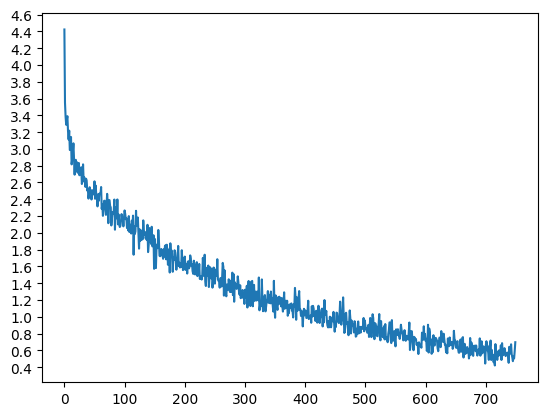

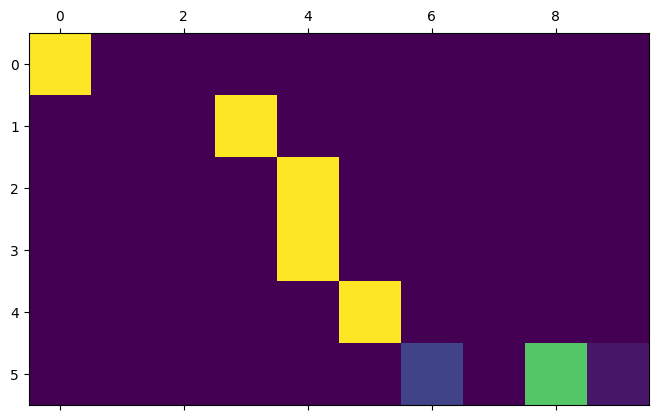

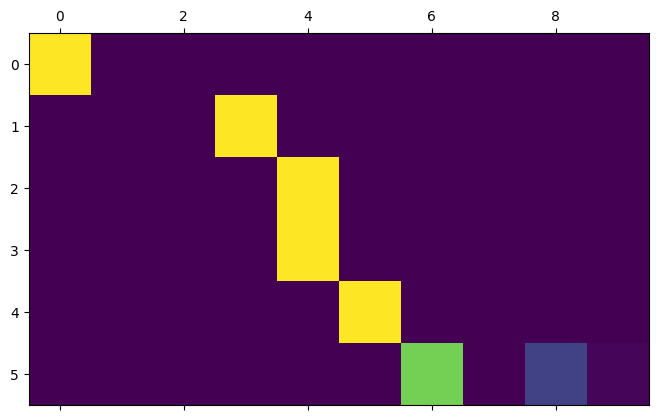

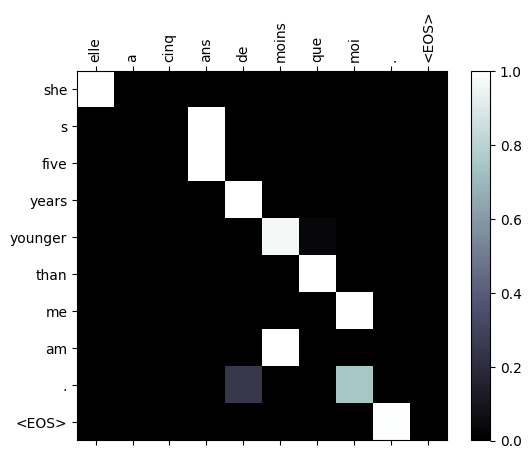

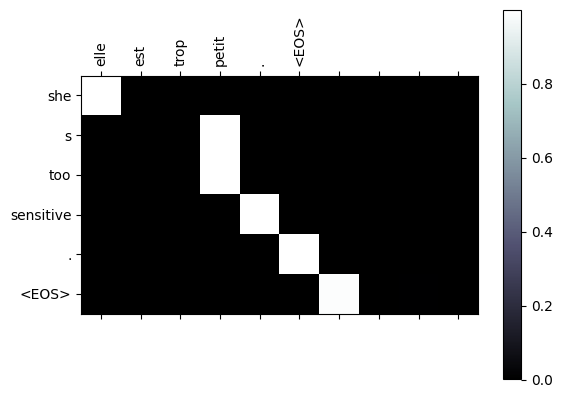

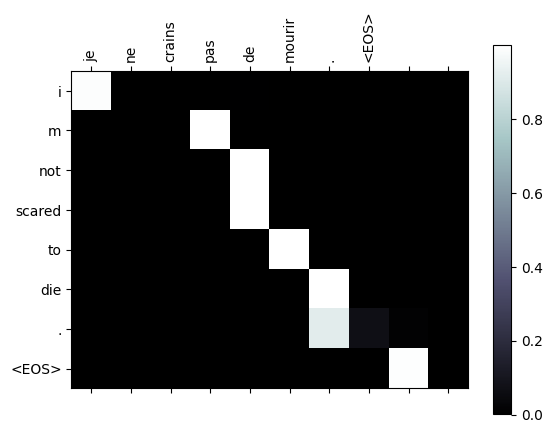

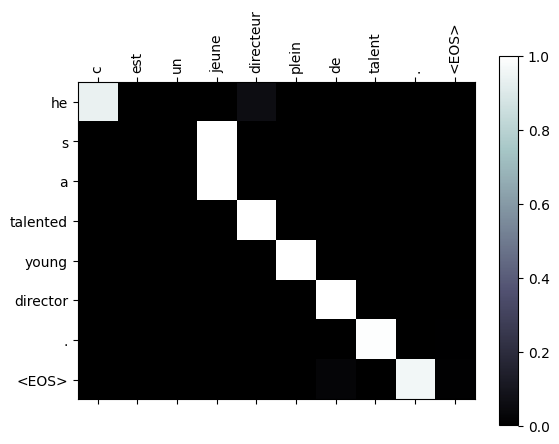

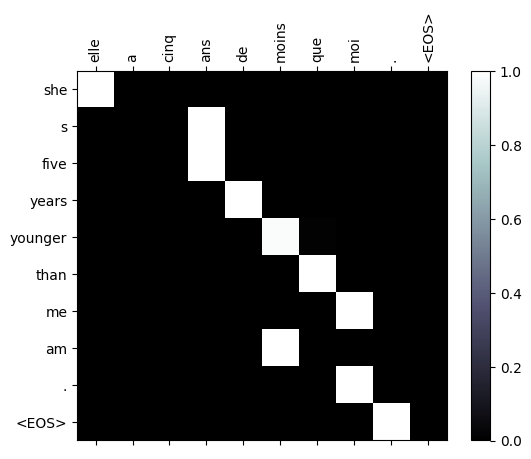

input = elle est trop petit .
output = she s too short . <EOS>


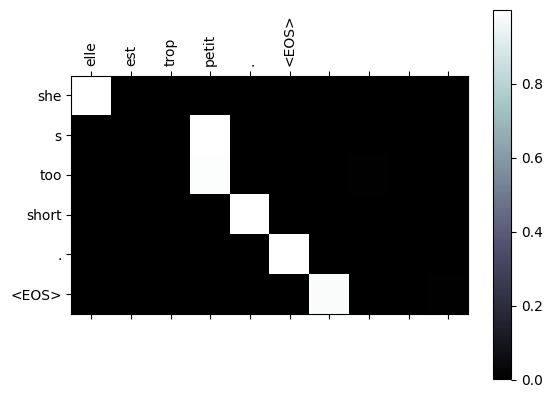

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


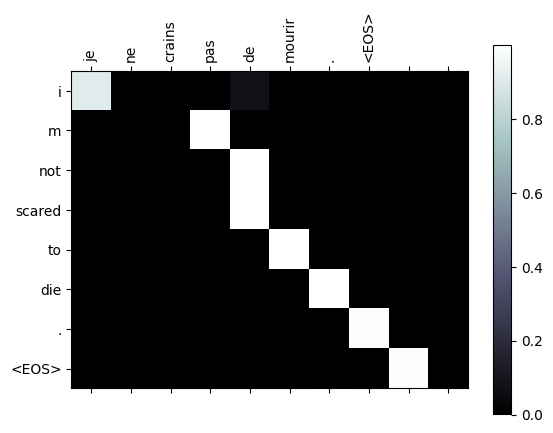

input = c est un jeune directeur plein de talent .
output = he s a very talented young . <EOS>


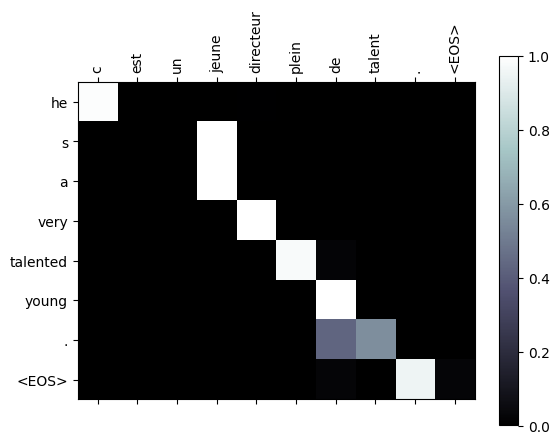

In [30]:
# 라벨과 축 더해서 보기
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence
    )
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

`%matplotlib inline` 명령어를 학습 종료 후 실행해서 그래프 위치 이상함